In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import time
import torchvision
import sys
import os
import torch
import torch.nn.functional as F
import argparse
import cv2
import numpy as np
from glob import glob
import copy
from collections import OrderedDict
from tqdm import tqdm
import pandas as pd
from argparse import ArgumentParser
from torchvision.datasets import CIFAR10 as data_cifar
from torchvision.transforms import Normalize, ToTensor, Compose, RandomCrop, RandomHorizontalFlip, Resize
from easydict import EasyDict
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
# Upload resnet.py from the project folder with Google Chrome as the browser in colaboratory. 

from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)
src = list(files.upload().values())[0]
open('resnet.py','wb').write(src)
import resnet 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Saving resnet.py to resnet.py


In [4]:
# Upload dataloader_pytorch.py from the project folder with Google Chrome as the browser in colaboratory. 

src = list(files.upload().values())[0]
open('dataloader_pytorch.py', 'wb').write(src)
import dataloader_pytorch

Saving dataloader_pytorch.py to dataloader_pytorch.py


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/kaokore.zip", 'r')
zip_ref.extractall("./kaokore")

zip_ref.close()

In [0]:
class_label = ['noble', 'warrior', 'incarnation', 'commoner'] # class name
class_N = len(class_label) # class number
img_height, img_width = 128, 128 # image size
channel = 3
args = EasyDict({"lr": 0.1, "resume":False})

transform_train = Compose([
    Resize(128),
    RandomCrop(size = (128, 128), padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_test = Compose([
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
trainset = dataloader_pytorch.Kaokore(
    root='./kaokore/kaokore', split="train", transform=transform_train)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)

testset = dataloader_pytorch.Kaokore(
    root='./kaokore/kaokore', split="test", transform=transform_test)
valset = dataloader_pytorch.Kaokore(
    root='./kaokore/kaokore', split="dev", transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)


In [8]:
print("The length of training set is:", len(trainset))
print("The length of test set is:", len(testset))
print("The length of validation set is:", 5552 - len(trainset) - len(testset))

The length of training set is: 4238
The length of test set is: 527
The length of validation set is: 787


In [6]:
device = 'cuda'
net = resnet.ResNetKaokore().to(device)
net = torch.nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr ,
                      momentum=0.9, weight_decay = 6e-4)

# Training
scheduler = MultiStepLR(optimizer, milestones=[20, 30,40], gamma=0.1)
train_losses = list()
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
    train_losses.append(train_loss)
    print("Training accuracy:", correct/total)

test_losses = list()
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        test_losses.append(test_loss)
    print("Testing accuracy:", correct/total)

for epoch in range(0, 50):
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(epoch)
    scheduler.step()
    test(epoch)


current lr 1.00000e-01

Epoch: 0
Training accuracy: 0.7508258612553091
Testing accuracy: 0.7628083491461101
current lr 1.00000e-01

Epoch: 1
Training accuracy: 0.7741859367626239
Testing accuracy: 0.7495256166982922
current lr 1.00000e-01

Epoch: 2
Training accuracy: 0.7902312411514866
Testing accuracy: 0.7514231499051234
current lr 1.00000e-01

Epoch: 3
Training accuracy: 0.7911750825861256
Testing accuracy: 0.7533206831119544
current lr 1.00000e-01

Epoch: 4
Training accuracy: 0.7961302501179802
Testing accuracy: 0.7590132827324478
current lr 1.00000e-01

Epoch: 5
Training accuracy: 0.8008494572911751
Testing accuracy: 0.7343453510436433
current lr 1.00000e-01

Epoch: 6
Training accuracy: 0.8029731005191127
Testing accuracy: 0.5996204933586338
current lr 1.00000e-01

Epoch: 7
Training accuracy: 0.8121755545068429
Testing accuracy: 0.49146110056925996
current lr 1.00000e-01

Epoch: 8
Training accuracy: 0.8289287399716847
Testing accuracy: 0.7609108159392789
current lr 1.00000e-01

Epo

In [1]:
print("The length of training set is:", len(trainset))

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]
def plot_losses(train_losses, test_losses):
    x = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, test_losses, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

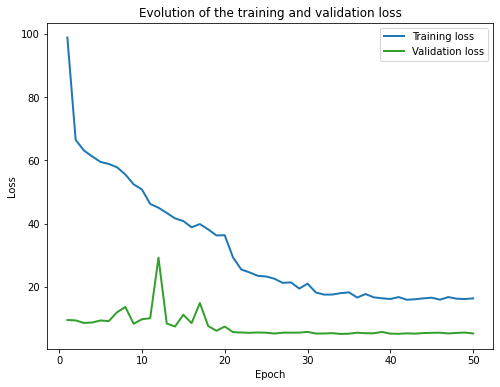

In [14]:
plot_losses(train_losses, test_losses)